In [1]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision.transforms import v2
import yaml
import numpy as np
import pandas as pd
import clearml
import matplotlib.pyplot as plt
import seaborn
import os

import warnings
warnings.filterwarnings(action='ignore')
%matplotlib inline

torch.cuda.is_available()

True

In [2]:
import ssl
import certifi

ssl._create_default_https_context = ssl.create_default_context
ssl._create_default_https_context.cafile = certifi.where()

In [3]:
task = clearml.Task.init(project_name="Caption generator", task_name="Selecting encoder", tags=['encoder', 'feature_extraction'])
logger = task.get_logger()

CONFIG_PATH = './config.yaml'

ClearML Task: overwriting (reusing) task id=f4b06d6a90d5486aa68f3c4398c40771
ClearML results page: https://app.clear.ml/projects/22856c5ce3ac4602a83e933c56a4600a/experiments/f4b06d6a90d5486aa68f3c4398c40771/output/log
ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


## Encoders factory

In [4]:
class BaseEncoder(nn.Module):
    def __init__(self, embedding_dim=None):
        super().__init__()
        self.embedding_dim=None
        self.features_dim=None

    def forward(self, x):
        pass

    def get_features_dim(self):
        return self.features_dim

In [5]:
class ResNet50(BaseEncoder):
    def __init__(self, embedding_dim=256, pretrained=True):
        super().__init__(embedding_dim)
        model = models.resnet50(pretrained=pretrained)
        self.features = nn.Sequential(*list(model.children())[:-1])

        self.feature_dim = 2048

    def forward(self, x):
        features = self.features(x)
        out = torch.flatten(features, 1)

        return out

In [6]:
class ResNet101(BaseEncoder):
    def __init__(self, embedding_dim=256, pretrained=True):
        super().__init__(embedding_dim)
        model = models.resnet101(pretrained=pretrained)
        self.features = nn.Sequential(*list(model.children())[:-1])

        self.feature_dim = 2048

    def forward(self, x):
        features = self.features(x)
        out = torch.flatten(features, 1)

        return out

In [7]:
class EfficientNet(BaseEncoder):
    def __init__(self, embedding_dim=256, model_name='efficientnet_b0', pretrained=True):
        super().__init__(embedding_dim)
        weights = 'DEFAULT' if pretrained else None
        if model_name == 'efficientnet_b0':
            model = models.efficientnet_b0(weights=weights)
        elif model_name == 'efficientnet_b4':
            model = models.efficientnet_b4(weights=weights)
        else:
            raise ValueError('Unknown model (efficient net)')

        self.feature_dim = 1280 if 'b0' in model_name else 1792
        self.features = nn.Sequential(*list(model.children())[:-1])

    def forward(self, x):
        features = self.features(x)
        out = torch.flatten(features, 1)

        return out

In [8]:
class EncoderFactory:
    @staticmethod
    def create_encoder(encoder_name, embedding_dim=256, pretrained=True):
        all_encoders = {
            "resnet50": ResNet50,
            "resnet101": ResNet101,
            "efficientnet_b0": lambda **kwargs: EfficientNet(model_name="efficientnet_b0", **kwargs),
            "efficientnet_b4": lambda **kwargs: EfficientNet(model_name="efficientnet_b4", **kwargs)
        }
        selected_encoder = all_encoders[encoder_name](
            embedding_dim=embedding_dim,
            pretrained=pretrained
        )

        return selected_encoder

In [9]:
import ssl
import urllib.request

ssl._create_default_https_context = ssl._create_unverified_context

import urllib.request as ur
ur._opener = None
os.environ['CURL_CA_BUNDLE'] = ''

## Dataset

In [10]:
with open(CONFIG_PATH, 'r') as config:
    cfg = yaml.safe_load(config)

task.connect_configuration(cfg)
DATA_PATH  = cfg['dataset']['path']

In [11]:
for picture in os.listdir(os.path.join(DATA_PATH, "images"))[:10]:
    print(picture, end = ' | ')

583087629_a09334e1fb.jpg | 2641770481_c98465ff35.jpg | 530950375_eea665583f.jpg | 2872197070_4e97c3ccfa.jpg | 2369452202_8b0e8e25ca.jpg | 2789937754_5d1fa62e95.jpg | 543326592_70bd4d8602.jpg | 3173461705_b5cdeef1eb.jpg | 528500099_7be78a0ca5.jpg | 353180303_6a24179c50.jpg | 

In [12]:
from PIL import Image
from nltk.tokenize import word_tokenize

class FlickrDataset(Dataset):
    def __init__(self, dataset_size, data_path=DATA_PATH, transform=None):
        super().__init__()
        self.config = config
        self.data_path = data_path
        self.transform = transform

        self.images = os.path.join(data_path, "images")
        self.labels = os.path.join(data_path, "captions.txt")
        self.image_caption = []
        self._preprocess_labels()


        self.image_caption = self.image_caption[:dataset_size]
        self.images_idx = [pair[0] for pair in self.image_caption]
        self.labels_idx = [pair[1] for pair in self.image_caption]
    

    def _preprocess_labels(self):
        with open(self.labels, 'r', encoding='utf-8') as f: 
            next(f) #first row contains image,caption info
            for line in f:
                filename, label = line.strip().split(",", 1)
                tokens = word_tokenize(label)
                self.image_caption.append((filename, tokens))
    
    def __len__(self):
        return len(self.images_idx)

    def __getitem__(self, idx):
        image_name = self.images_idx[idx]
        label = self.labels_idx[idx]

        image = Image.open(os.path.join(self.data_path, "images", image_name)).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, label

In [13]:
first_file = os.path.join(DATA_PATH, 'images', os.listdir(os.path.join(DATA_PATH, 'images'))[0])

image_size = Image.open(first_file).convert('RGB').size

## Class for all needed tests

In [14]:
import time
from scipy import stats as scipy_stats

class ComparisonTests:
    @staticmethod
    def num_parameters(model, return_trainable=True):
        total_params, trainable_params = [], []
        for p in model.parameters():
            total_params.append(p.numel())
            if return_trainable and p.requires_grad:
                trainable_params.append(p.numel())

        total_sum, trainable_sum = sum(total_params), sum(trainable_params)
        total_trainable_ratio = trainable_sum / total_sum

        return {
            'total_params': total_sum,
            'trainable_params': trainable_sum,
            'total_trainable_ratio': total_trainable_ratio
        }

    @staticmethod
    def model_inference_time(model, test_loader, device, n_batches):
        model = model.to(device)
        model.eval()

        times = []
        with torch.no_grad():
            for idx, (images, _) in enumerate(test_loader):
                if idx >= n_batches:
                    break

                images = images.to(device)

                start = time.time()
                _ = model(images)
                torch.cuda.synchronize()
                end = time.time()

                times.append(end - start)

        sum_time = sum(times)
        mean_time = np.mean(times)
        batch_shape = images.shape[0]

        return {
            'sum_time_ms': sum_time * 1000,
            'mean_time_ms': mean_time * 1000,
            'throughput_images_per_sec': batch_shape / mean_time
        }
        

    @staticmethod
    def model_memory_usage(model, device='cuda'):
        model = model.to(device)
        param_memory = sum(p.numel() * 4 for p in model.parameters()) / (1024 ** 2)
        buffer_memory = sum(b.numel() * 4 for b in model.buffers()) / (1024 ** 2)
        dummy_input = torch.randn(32, 3, 224, 224).to(device)
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.empty_cache()
        
        with torch.no_grad():
            _ = model(dummy_input)
        
        activation_memory = torch.cuda.max_memory_allocated() / (1024 ** 2)
        
        return {
            'param_memory_mb': param_memory,
            'buffer_memory_mb': buffer_memory,
            'activation_memory_mb': activation_memory,
            'total_memory_mb': param_memory + buffer_memory + activation_memory
        }

    @staticmethod
    def compute_main_statistics(model, test_loader, device='cuda', n_batches=10):
        model = model.to(device)
        model.eval()
    
        features = []
        with torch.no_grad():
            for idx, (images, _) in enumerate(test_loader):
                images = images.to(device)
                
                f = model(images)
                f = f.view(f.size(0), -1)
                features.append(f.cpu())
                
                if idx >= n_batches - 1:
                    break
    
        features = torch.cat(features, dim=0)
        stats = {}
    
        var_per_dim = torch.var(features, dim=0)
        stats['var_mean'] = var_per_dim.mean().item()
        stats['dead_features_ratio'] = (var_per_dim < 1e-5).float().mean().item()
    
        corr_matrix = torch.corrcoef(features.T)
        mask = ~torch.eye(corr_matrix.size(0), dtype=bool)
        stats['mean_abs_corr'] = corr_matrix[mask].abs().mean().item()
    
        fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    
        ax = axes[0, 0]
        ax.hist(features.flatten().numpy(), bins=100, density=True, alpha=.7)
        ax.set_title('Distribution of All Feature Values')
        ax.set_xlabel('Feature Value')
        ax.set_ylabel('Density')
        ax.axvline(features.mean().item(), color='r', linestyle='--', label=f'Mean: {features.mean().item():.2f}')
        ax.axvline(features.median().item(), color='g', linestyle='--', label=f'Median: {features.median().item():.2f}')
        ax.legend()
        
        ax = axes[0, 1]
        dim_means = features.mean(dim=0).numpy()
        ax.hist(dim_means, bins=50, alpha=0.7, edgecolor='black')
        ax.set_title('Distribution of Per-Dimension Means')
        ax.set_xlabel('Mean Value')
        ax.set_ylabel('Count')
        
        ax = axes[1, 0]
        dim_vars = torch.var(features, dim=0).numpy()
        ax.hist(dim_vars, bins=50, alpha=0.7, edgecolor='black', color='orange')
        ax.set_title('Distribution of Per-Dimension Variance')
        ax.set_xlabel('Variance')
        ax.set_ylabel('Count')
        
        ax = axes[1, 1]
        scipy_stats.probplot(features.flatten().numpy(), dist="norm", plot=ax)
        ax.set_title('QQ-plot')
        
        plt.tight_layout()
        
        return stats, features, fig

    @classmethod
    def comparison_tests(cls, model, test_loader, device='cuda', return_trainable=True, n_batches=10):
        params_dict = cls.num_parameters(model, return_trainable)
        inference_dict = cls.model_inference_time(model, test_loader, device, n_batches)
        memory_dict = cls.model_memory_usage(model, device)
        stats_dict, features, fig = cls.compute_main_statistics(model, test_loader, device, n_batches)

        return params_dict, inference_dict, memory_dict, stats_dict, features, fig

Computing optimal mean / std for each channel

In [15]:
def compute_mean_std(dataset, batch_size, num_workers, collate_fn):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_fn)

    mean = torch.zeros(3)
    std = torch.zeros(3)
    total_samples = 0

    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, 3, -1)

        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)

        total_samples += batch_samples

    mean /= total_samples
    std /= total_samples

    return mean, std

In [16]:
def collate_fn(batch):
    images = torch.stack([item[0] for item in batch])
    labels = [item[1] for item in batch]

    return images, labels

In [17]:
transform_row = v2.Compose([
    v2.Resize(size=(224, 224)),
    v2.ToTensor()
])

total_size = cfg['dataset']['train_size'] + cfg['dataset']['test_size']
dataset = FlickrDataset(dataset_size=total_size, data_path=cfg['dataset']['path'], transform=transform_row)
optimal_mean, optimal_std = compute_mean_std(
    dataset, batch_size=cfg['evaluation']['batch_size'], num_workers=cfg['evaluation']['num_workers'], collate_fn=collate_fn
)

print("Optimal mean: {} | Optimal std: {}".format(optimal_mean, optimal_std))

Optimal mean: tensor([0.4463, 0.4506, 0.4166]) | Optimal std: tensor([0.2235, 0.2138, 0.2222])


In [18]:
total_size = cfg['dataset']['train_size'] + cfg['dataset']['test_size']
transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToTensor(),
    v2.Normalize(mean=optimal_mean, std=optimal_std)
])

## Logging into ClearML

Working with resnet50...
Working with resnet101...
Working with efficientnet_b0...
Working with efficientnet_b4...


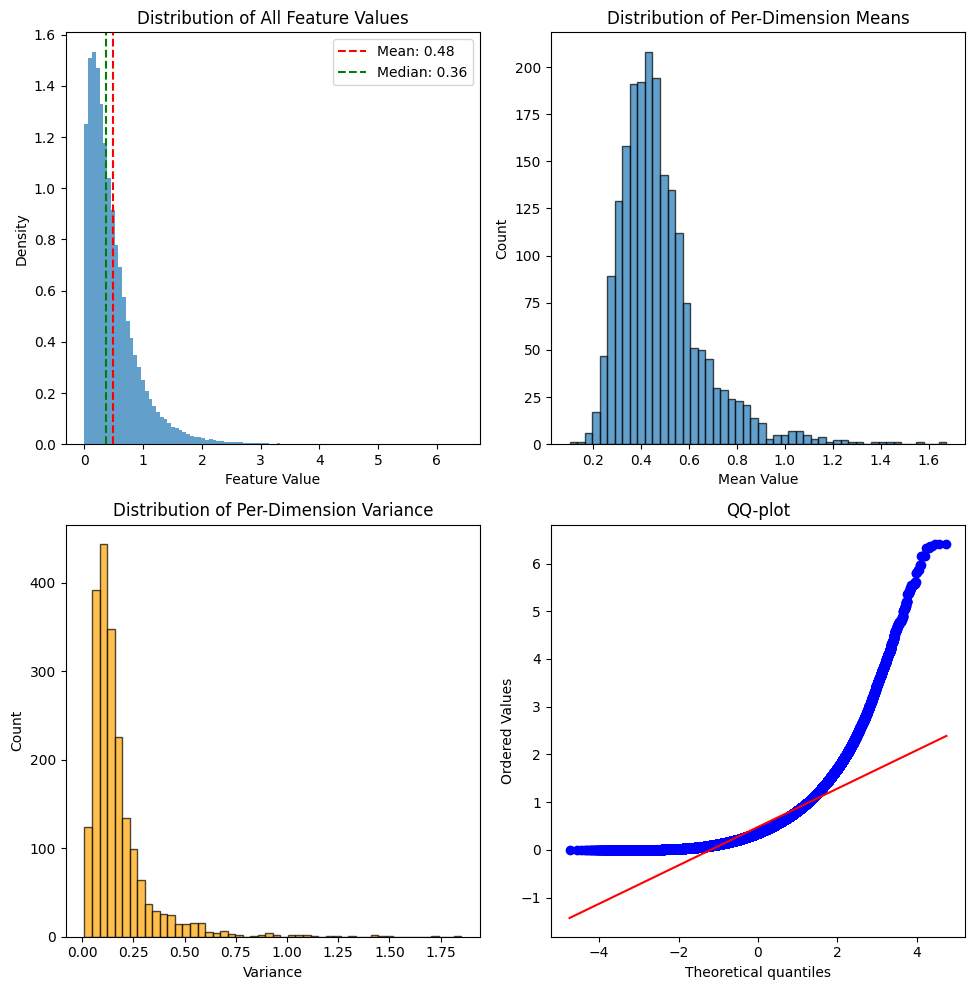

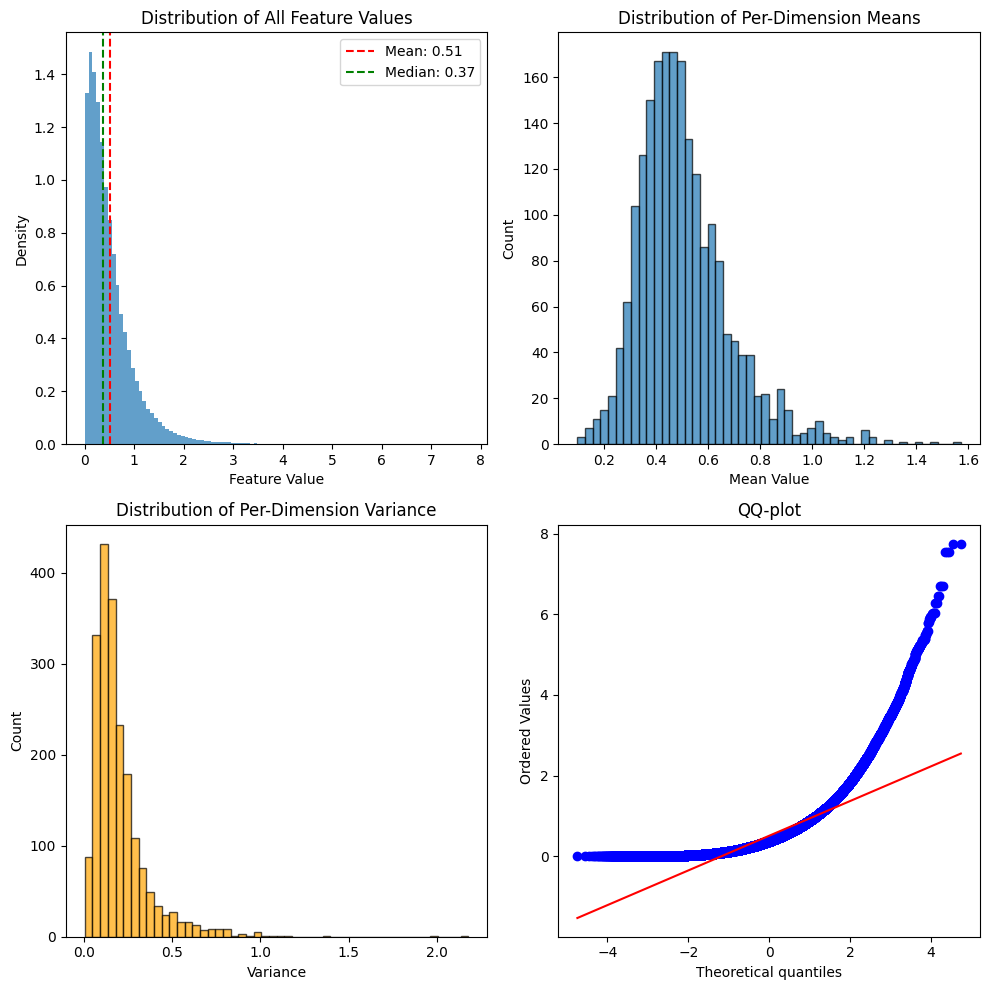

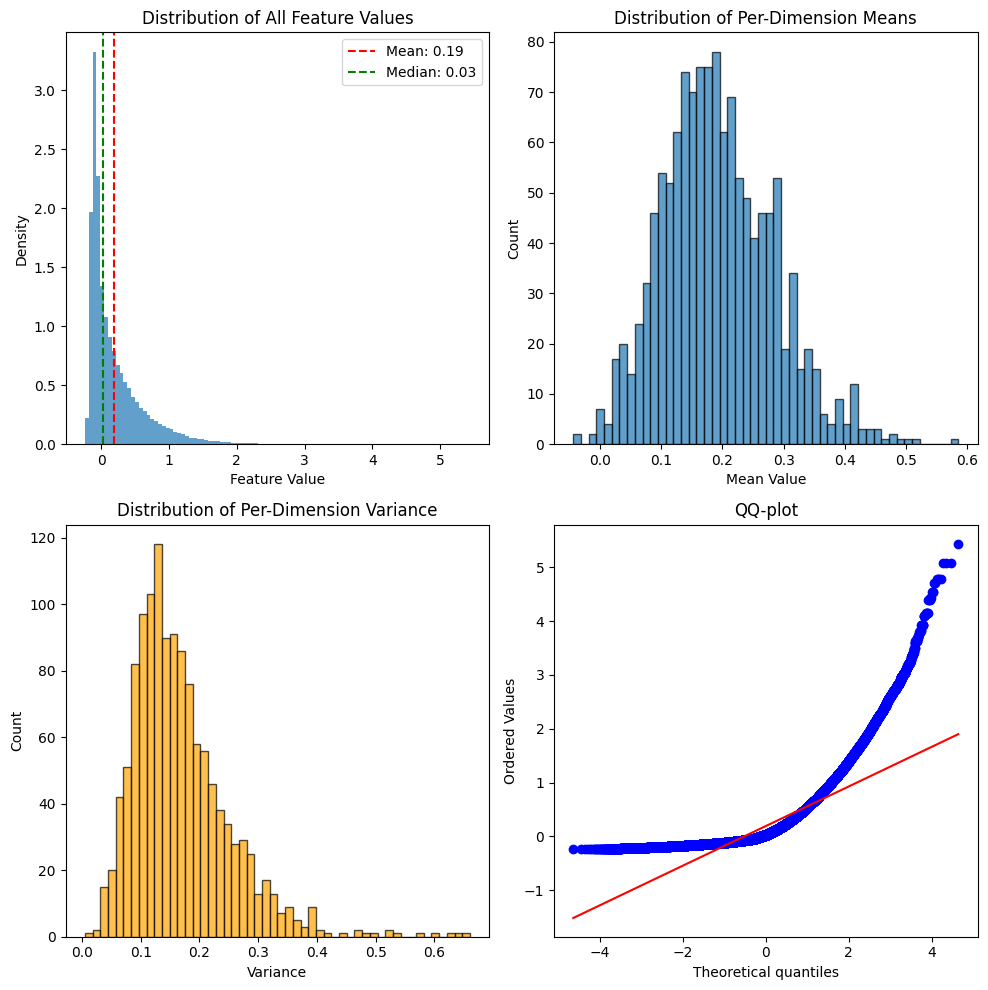

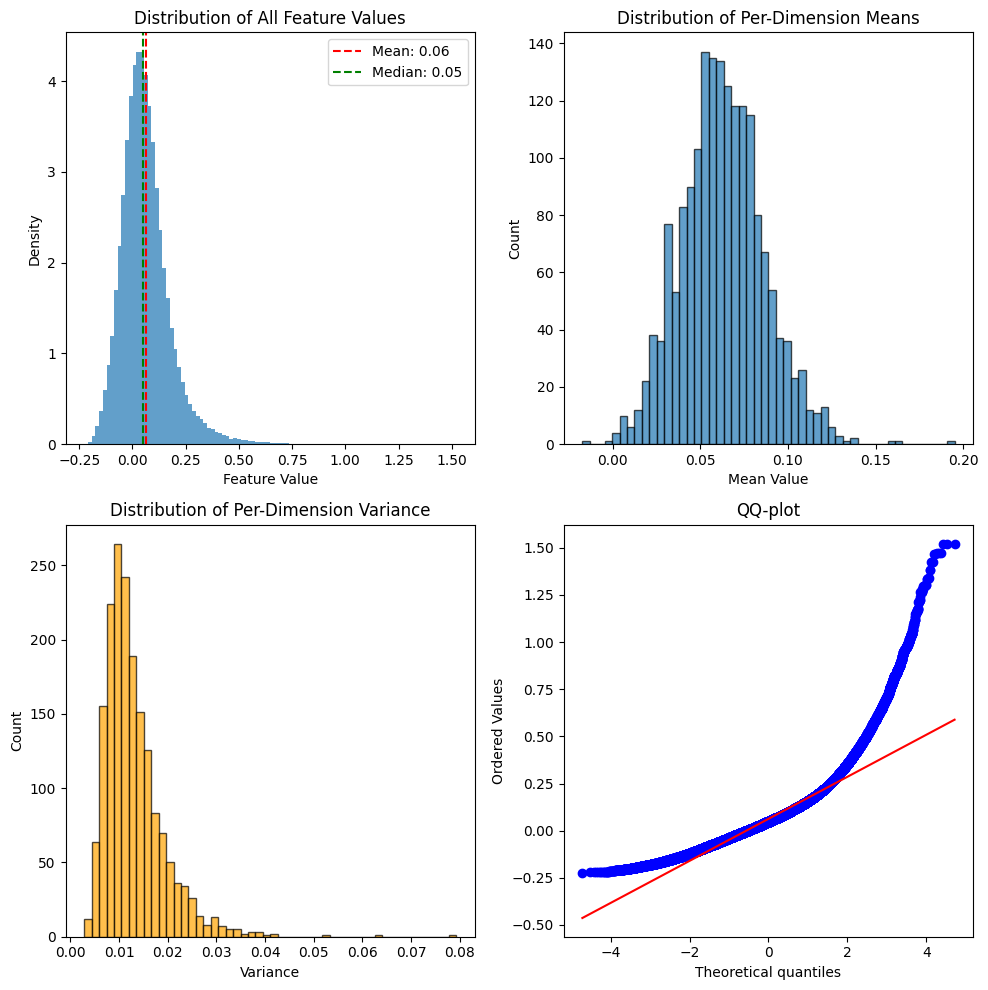

In [19]:
device = cfg['evaluation']['device']
batch_size = cfg['evaluation']['batch_size']
return_trainable = True
n_batches = 10


dataset = FlickrDataset(dataset_size=total_size, data_path=cfg['dataset']['path'], transform=transform)
test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

for idx, model_name in enumerate(cfg['encoders']):
    print(f'Working with {model_name}...')
    model = EncoderFactory.create_encoder(model_name)
    params_dict, inference_dict, memory_dict, stats_dict, features, fig = ComparisonTests.comparison_tests(
        model, test_loader, device, return_trainable, n_batches
    )

    all_dicts = [
        (params_dict, 'Parameters', 'amount'),
        (inference_dict, 'Inference time', 'ms'), 
        (memory_dict, 'Memory usage', 'mb'), 
        (stats_dict, 'Main statistics', 'value')
    ]
    # report everything
    for d in all_dicts:
        for key in d[0].keys():
            logger.report_single_value(name=f'{model_name}/{key}', value=d[0][key])

        # also report as table for more readability in UI
        d_series = pd.Series(d[0])
        d_frame = d_series.to_frame(d[2])
    
        logger.report_table(
            title=f'{model_name}/comparison',
            series=d[1],
            table_plot=d_frame
        )

    logger.report_matplotlib_figure(
        title=f'{model_name}/features_distribution_details',
        series='distribution',
        figure=fig
    )